In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import os
import rioxarray
import re
import matplotlib.patches as patches
from tqdm import tqdm

# Data Load

In [2]:
# Load US Map
map_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/tlgpkg_2024_a_us_nationgeo.gpkg")
map_5070 = map_gdf.to_crs(epsg=5070)

# Load the levees file
levees_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/levees.gpkg")

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'tlgpkg_2024_a_us_nationgeo.gpkg': 'State' (default), 'Core_Based_Statistical_Area', 'Combined_Statistical_Area', 'Metropolitan_Division', 'ZIP_Code_Tabulation_Area_5_Digit_20', 'Urban_Area_20'. Specify layer parameter to avoid this warning.
  result = read_func(
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


In [ ]:
# CRS5070 boundaries for contiguous US
min_lat, max_lat = 20, 50
min_lon, max_lon = -130, -60

def is_contiguous_us(filename):
    match = re.search(r'n(\d+)w(\d+)|n(\d+)e(\d+)', filename)
    if match:
        lat = int(match.group(1) or match.group(3))
        lon = -int(match.group(2) or match.group(4)) if 'w' in filename else int(match.group(4))
        return min_lat <= lat <= max_lat and min_lon <= lon <= max_lon
    return False

In [4]:
# Load data
data_dir = "/share/gpu5/ucapmgb/levee-hunter/data/raw/13_resolution_original"
og_tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
print("Number of .tif files:", len(og_tif_files))

# Filter files
og_contiguous_us_files = [f for f in og_tif_files if is_contiguous_us(f)]

print("After filtering:", len(og_contiguous_us_files))

OG_tifs = [rioxarray.open_rasterio(os.path.join(data_dir, f)) for f in tqdm(og_contiguous_us_files)]

Number of .tif files: 762
After filtering: 714


100%|██████████| 714/714 [00:02<00:00, 282.77it/s]


# Population Density vs Known Levees

In [ ]:
# Load the population density file
population_density_tif = rioxarray.open_rasterio("/home/ucapmgb/levee-hunter/data/raw/levees/usa_pd_2020_1km.tif")

In [6]:
# Load all contiguous tifs and get bounds
og_bounds = [t.rio.bounds() for t in OG_tifs]

In [7]:
# Convert TIF values below 0 to NaN
population_density_tif = population_density_tif.where(population_density_tif >= 0)
# Apply logarithmic transformation to population density values
population_density_tif = np.log1p(population_density_tif)

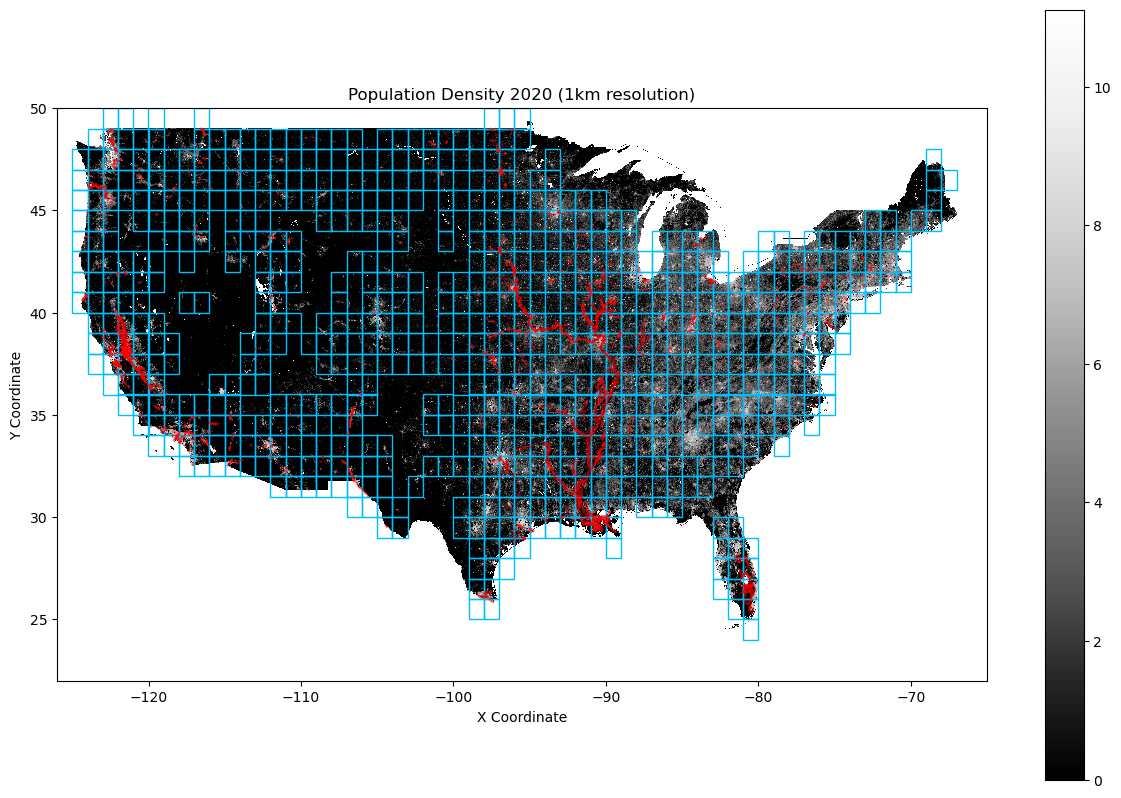

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
population_density_tif.plot(ax=ax, cmap='Grays_r')

# Plot the bounds of each image
for i, bound in enumerate(og_bounds):
    rect = patches.Rectangle((bound[0], bound[1]), bound[2] - bound[0], bound[3] - bound[1], linewidth=1, edgecolor='deepskyblue', facecolor='none', label=f'Image {i+1}' if i == 0 else "")
    ax.add_patch(rect)

levees_gdf.plot(ax=ax, color='red', alpha=0.5)

min_lat, max_lat = 22, 50
min_lon, max_lon = -126, -65

# Set axis limits to only contiguous USA
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plt.title('Population Density 2020 (1km resolution)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# US Cities vs Levees
### Selecting TIF files for Training

In [9]:
# US Cities Coordinates
US_Cities = {
   "Los Angeles": (34.0522, -118.2437),
   "Philadelphia": (39.9526, -75.1652),
   "Dallas": (32.7767, -96.7970),
   "Chicago": (41.8781, -87.6298),
   "Houston": (29.7604, -95.3698),
   "Kansas City": (39.0997, -94.5786),
   "Phoenix": (33.4484, -112.0740),
   "San Diego": (32.7157, -117.1611),
   "New York": (40.7128, -74.0060),
   "San Jose": (37.3382, -121.8863),
   "Salt Lake City": (40.7608, -111.8910),
   "Denver": (39.7392, -104.9903),
   "Omaha": (41.2565, -95.9345),
   "Albuquerque": (35.0844, -106.6504),
   "Sacramento": (38.5816, -121.4944),
   "St. Louis": (38.6270, -90.1994),
   "Scranton": (41.4080, -75.6624),
   "Memphis": (35.1495, -90.0490),
   "Seattle": (47.6062, -122.3321),
   "Portland": (45.5051, -122.6750),
   "Orlando": (28.5383, -81.3792),
   "Miami": (25.7617, -80.1918),
   "Fargo": (46.8772, -96.7898),
   "Raleigh(ish)": (35.7796, -78.6382),
   "Indianapolis": (39.7684, -86.1581),
   "Cincinnati": (39.1031, -84.5120)
}

In [10]:
# List of top-left coordinates to search for (26 tiles)
top_left_coords = [(34, -117), (34, -118), (35, -118), (35, -119), # LA
                   (40, -75), (40, -76), (41, -75), (41, -76), #Philadelphia
                   (33, -97), (33, -98), (34, -97), (34, -98), #Dallas
                   (42, -88), (42, -89), (43, -89), #Chicago
                   (30, -96), (31, -95), (31, -96), #Houston
                   (39, -95), (40,-95), (40, -96), # Kansas City
                   (34, -112), (34, -113), #Phoenix
                   (33, -117), (33, -118), # San Diego
                   (41,-74),(42,-74), #NYC
                   (38, -122), (38, -123), # San Jose
                   (41, -112), (41, -113), # Salt Lake City
                   (40, -106), (40, -105), # Denver
                   (42, -97), (42, -96), # Omaha
                   (35, -107), (36, -107), # Albuquerque
                   (39, -122), # Sacramento
                   (39, -91), # St. Louis
                   (42, -76), # Scranton
                   (36, -91), # Memphis
                   (48, -123), # Seattle
                   (46, -123), # Portland
                   (29, -82), # Orlando
                   (27, -81), # Miami
                   (47, -97), # Fargo
                   (36, -78), # Raleigh-ish
                   (40, -87), # Indianapolis
                   (40, -85), # Cincinnati
                   ]

In [11]:
# Search for tifs with matching top-left coordinates by name
matching_tifs = [f for f in og_contiguous_us_files if any(f'n{lat:02d}w{abs(lon):03d}' in f for lat, lon in top_left_coords)]

# Output the matching tifs
print("No. TIFs:", len(matching_tifs))
print("Matching TIFs:", matching_tifs)

No. TIFs: 49
Matching TIFs: ['USGS_13_n27w081_20221103.tif', 'USGS_13_n29w082_20221103.tif', 'USGS_13_n30w096_20240229.tif', 'USGS_13_n31w095_20240229.tif', 'USGS_13_n31w096_20240229.tif', 'USGS_13_n33w097_20211124.tif', 'USGS_13_n33w098_20211124.tif', 'USGS_13_n33w117_20240327.tif', 'USGS_13_n33w118_20180313.tif', 'USGS_13_n34w097_20250102.tif', 'USGS_13_n34w098_20250102.tif', 'USGS_13_n34w112_20240402.tif', 'USGS_13_n34w113_20241016.tif', 'USGS_13_n34w117_20240327.tif', 'USGS_13_n34w118_20190917.tif', 'USGS_13_n35w107_20231208.tif', 'USGS_13_n35w118_20221019.tif', 'USGS_13_n35w119_20240207.tif', 'USGS_13_n36w078_20151125.tif', 'USGS_13_n36w091_20241002.tif', 'USGS_13_n36w107_20240416.tif', 'USGS_13_n38w122_20240207.tif', 'USGS_13_n38w123_20240826.tif', 'USGS_13_n39w091_20240228.tif', 'USGS_13_n39w095_20240408.tif', 'USGS_13_n39w122_20240313.tif', 'USGS_13_n40w075_20210624.tif', 'USGS_13_n40w076_20220524.tif', 'USGS_13_n40w085_20230407.tif', 'USGS_13_n40w087_20210617.tif', 'USGS_13_n4

In [12]:
selected_tifs = [rioxarray.open_rasterio(os.path.join(data_dir, f)) for f in tqdm(matching_tifs)]
bounds_selected = [t.rio.bounds() for t in selected_tifs]

100%|██████████| 49/49 [00:00<00:00, 257.77it/s]


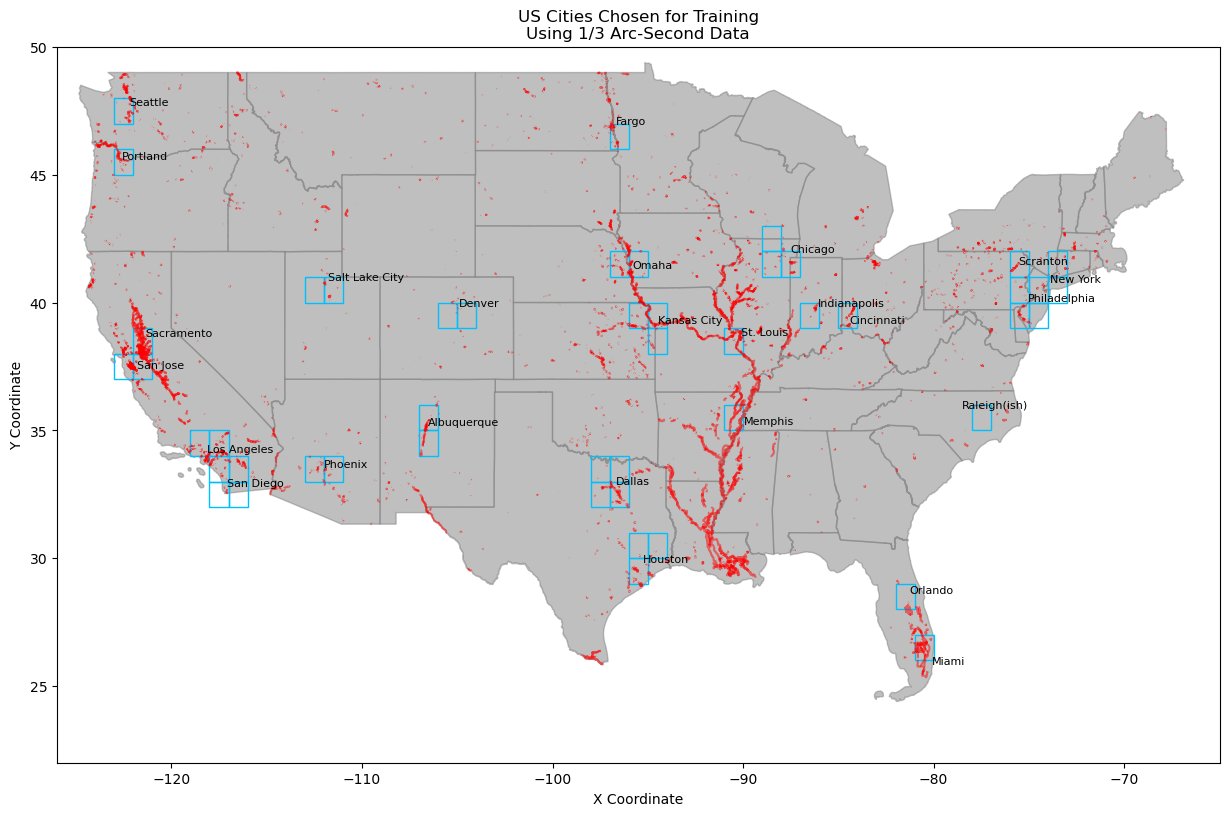

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

# USA Map
map_gdf.plot(ax=ax, color='grey', alpha=0.5, edgecolor='grey')

# USA Cities
for city, coords in US_Cities.items():
    ax.scatter(*coords, color='darkblue')
    ax.text(coords[1]+0.1, coords[0]+0.1, city, fontsize=8)

# Plot the bounds of each image
for i, bound in enumerate(bounds_selected):
    rect = patches.Rectangle((bound[0], bound[1]), bound[2] - bound[0], bound[3] - bound[1], linewidth=1, edgecolor='deepskyblue', facecolor='none', label=f'Image {i+1}' if i == 0 else "")
    ax.add_patch(rect)

levees_gdf.plot(ax=ax, color='red', alpha=0.5)

min_lat, max_lat = 22, 50
min_lon, max_lon = -126, -65

# Set axis limits to only contiguous USA
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plt.title('US Cities Chosen for Training\nUsing 1/3 Arc-Second Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()